In [1]:
import os
wd = os.getcwd()
wd = os.path.dirname(os.path.dirname(wd))
import sys
sys.path.append(wd+"\\src\\")

In [2]:
from tube import Tube, InterpXY, BorderSimple
from gaslayer import GasEOS, GasFluxCalculator, GridStrecher, GasLayer
from math import *
import numpy as np

In [3]:
from tqdm import tqdm_notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets

%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (5,3) 

In [4]:
pi


3.141592653589793

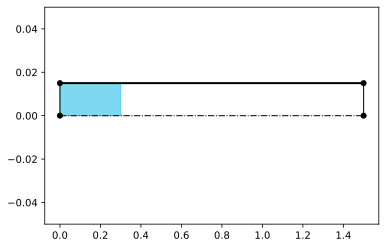

GasLayer(n_cells=300); 
        {'p_max':30000000.0, 'tau_min': 2.880277994805242e-06, 
        'u_max': 0.0, 'cs_max': 347.18870949384285, 'dx_min': 0.0009999999999999454, 
        'x_1': 0.0, 'x_2': 0.3,
        'V_1':  0.0, 'V_2':  0.0  }

In [16]:
def get_layer0(l_0, p_0, n_cells=300, d=30e-3):   
    ro_0 = p_0/(287*300)
    S = pi * d**2/4
    l = d * 50
#    S*ro_0 l_0  = m_g / () 
    gas_layer_dict_sample = {
        'type': 'gas',
        'name': 'air',
        'gamma': 1.4,
        'kappa': 0,
        'R': 287,
        'T_0': 300, # K
        'W_0': 0.0003,  # м^3 объем газа
        'p_0': p_0, # начальное давление газа
        'u_0': 0,     #начальная скорость
        'x_2': l_0
    }

    tube_dict = {
        'tube_points': [[0, d], [l, d]]
    }

    calc_settings_sample = {
        'cell_dx': 0.0025,
        'n_cells': n_cells,
        'n_cells_min': 13,
        'n_cells_max': 300,
        'GasFluxCalculator_kwargs': { 'flux_type':2 },
        'GridStrecher_kwargs': {}
    }   
    tube=Tube.get_standart(tube_dict)
    gl = GasLayer.get_standart(tube, 0, gas_layer_dict_sample, calc_settings_sample)   
    return gl

gl = get_layer0(0.3, 30e6)
fig, ax = plt.subplots()
gl.tube.plot(fig, ax)
gl.plot(fig, ax)
ax.set_ylim(-0.05,0.05)
plt.show()

gl

In [27]:
def calc_sol_all(l_0, p_0, ku=0.5):
    gl = get_layer0(l_0, p_0 = p_0*1e6, n_cells=300)
    ro_0 = p_0*1e6/(287*300)
    S = pi * 0.03**2/4
    m_g = S * ro_0 * l_0
    m = 0.5 - m_g
    if m <=0:
        return [gl], m_g, m
    ku = 0.5
    lrs = [gl]
    for i in range(100000):
        if gl.xs_borders[-1] >= gl.tube.get_xs()[-1]:
            break
        tau = gl.get_tau_min()*ku
        v_left = gl.Vs_borders[-1] + gl.S[-1] * gl.ps[-1] / m * tau
        gl = gl.step_simple(tau, 0, v_left)
        lrs.append(gl)
    return lrs, m_g, m
lrs, m_g, m = calc_sol_all(l_0=0.5, p_0=30, ku=0.5)

def calc_sol(l_0, p_0):
    lrs, m_g, m = calc_sol_all(l_0, p_0)
    if m <0:
        return 0
    V = lrs[-1].Vs_borders[-1]
    return V**2/2*m
m_g

0.12314605349437341

In [28]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(lrs)-1,step=10, value=0))
def plotMe(ind):
    param_name = 'us'
    lr = lrs[ind]
    fig, ax = plt.subplots()
    xs = np.array(lr.xs_cells)
    ys = np.array(getattr(lr, param_name))
    color = lr.color_4_plot
    lw = 2
    ax.plot(xs, ys, color=color, lw=lw)
    plt.grid(True)
    plt.ylabel(param_name)
#     plt.ylim(-1,1)
    plt.title(f't={lr.time*1000} ms; i={ind}')
    plt.show()

interactive(children=(IntSlider(value=0, description='ind', max=2496, step=10), Output()), _dom_classes=('widg…

In [26]:
%matplotlib inline

In [30]:
from scipy.optimize import minimize
from scipy import optimize

Es = []
xs = []

def min_foo(x):
    E = calc_sol(l_0=x[0], p_0=x[1])
    Es.append(E)
    xs.append((x[0], x[1]))
    return -E

optimize.differential_evolution(min_foo, bounds = [(0.1, 1.4), (1, 50)])

     fun: -13069.174634932118
     jac: array([-34086.22687857,   -347.51610656])
 message: 'Optimization terminated successfully.'
    nfev: 588
     nit: 13
 success: True
       x: array([ 0.50807335, 49.96520564])

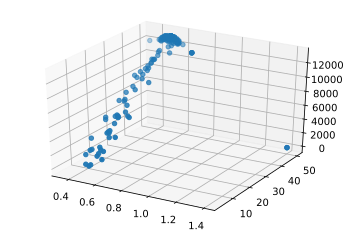

In [31]:
from functional import seq

fig = plt.figure()
ax = fig.gca(projection='3d')

n = 330
ls = seq(xs[-n:]).map(lambda x: x[0]).to_list()
ps = seq(xs[-n:]).map(lambda x: x[1]).to_list()

ax.scatter3D(ls, ps, Es[-n:])
plt.show()

Итого:

Найти максимальную кинетическую энергию метаемого тела массы m для калибра d=30 мм. Общая длина трубы не должна превышать n = 50 калибров. Максимальное давление газа не должно превышать 50 МПа. Газ - воздух. Газ считать холодным (T_0=300 К). Суммарная масса газа и метаемого тела не должна превышать 500 грамм. 